In [2]:
import os
os.chdir('..')

In [3]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [4]:
from tonal import pianoroll2number, joint_prob2pianoroll96
from tonal import tonal_centroid, chord482note, chord962note, note2number
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
from model.CVAE_lstm_decoder import CVAE
# from model.CTDCVAE_lstm_decoder_conv_prenet import CVAE
from decode import *
import matplotlib.pyplot as plt

In [5]:
melody_framewise = np.load('./data/melody_data.npy')
chord_groundtruth_idx = np.load('./data/chord_groundtruth.npy')

melody = np.load('./data/melody_baseline.npy')
chord = np.load('./data/number_96.npy')
chord_onehot = np.load('./data/onehot_96.npy')
length = np.load('./data/length.npy')

f = open('./data/tempos', 'rb')
tempos = pickle.load(f)
f.close()
f = open('./data/downbeats', 'rb')
downbeats = pickle.load(f)
f.close()

In [6]:
val_size = 500
print('splitting testing set...')
val_melody_framewise = melody_framewise[:val_size]
val_chord_groundtruth_idx = chord_groundtruth_idx[:val_size]

val_chord = torch.from_numpy(chord_onehot[:val_size]).float()
val_melody = torch.from_numpy(melody[:val_size]).float()
val_length = torch.from_numpy(length[:val_size])


splitting testing set...


In [8]:
# Load model
device = 'cpu'
print('building model...')
model = CVAE(device = device).to(device)
model.load_state_dict(torch.load('output_models/model_cvae_lstm_decoder.pth'))
# model.load_state_dict(torch.load('output_models/model_ctdcvae_conv_prenet.pth'))
print(model)
model.eval()
val_length, val_melody = val_length.to(device), val_melody.to(device)

building model...
CVAE(
  (encoder): LSTM(96, 256, num_layers=2, batch_first=True, bidirectional=True)
  (encoder_output2mean): Linear(in_features=512, out_features=16, bias=True)
  (encoder_output2logv): Linear(in_features=512, out_features=16, bias=True)
  (latent2decoder_input): Linear(in_features=592, out_features=128, bias=True)
  (decoder): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (outputs2chord): Linear(in_features=512, out_features=96, bias=True)
)


In [57]:
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            Make sure we keep at least min_tokens_to_keep per batch example in the output
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

tensor(16)
tensor([[ 0,  0,  0,  0, 56, 56, 56, 56, 73, 40, 40, 40, 40, 40,  0,  0]])


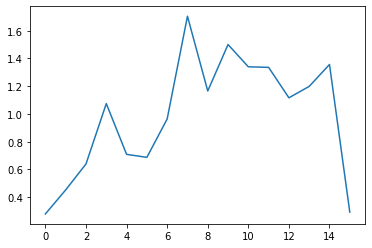

In [158]:
# Sampling
# torch.manual_seed(0)
i = 50
sample_melody = val_melody[i].unsqueeze(0)
sample_length = val_length[i]
sample_melody_framewise = np.expand_dims(val_melody_framewise[i],axis=0)
sample_chord_groundtruth_idx = np.expand_dims(val_chord_groundtruth_idx[i],axis=0)
sample_tempo = [tempos[i]]
sample_downbeat = [downbeats[i]]

print(sample_length)

latent_size = 16

# for k in range(10):
latent = torch.randn(1,272,latent_size)
z = torch.cat([latent,sample_melody], dim=-1)
output, chord_pred = model.decode(z)

gen_chord_index = torch.max(chord_pred[:,:sample_length],2).indices
print(gen_chord_index)
#     print(gen_chord_index.shape)

surprisingness = -np.log(torch.max(chord_pred[:,:sample_length],2).values.squeeze().detach().numpy())

fig, ax = plt.subplots()
ax.plot(surprisingness)

In [159]:
torch.max(chord_pred[:,:sample_length],2).values

tensor([[0.7563, 0.6361, 0.5276, 0.3415, 0.4923, 0.5031, 0.3815, 0.1819, 0.3118,
         0.2231, 0.2619, 0.2630, 0.3275, 0.3016, 0.2576, 0.7465]],
       grad_fn=<MaxBackward0>)

[0, 40, 56]
['F', 'A', 'C']


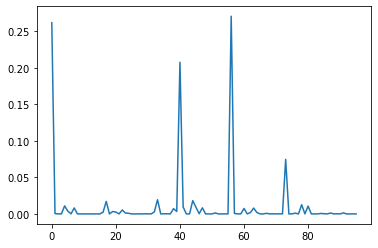

In [148]:
distribution = chord_pred[:,:sample_length].squeeze()[2].detach().numpy()

fig, ax = plt.subplots()
ax.plot(distribution)

print([x for x in range(96) if distribution[i] > 0.1])
print(chord962note(40))

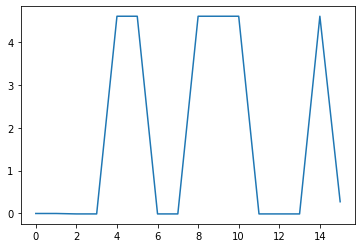

In [162]:
## Markov chain
def create_transition_matrix(seq,states):
    
    num_state = len(states) #number of states
    M = [[0]*num_state for _ in range(num_state)]
    
    # Convert seq to index seq
    index_seq = [states.index(i) for i in seq]

    for (i,j) in zip(index_seq,index_seq[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
            
    return np.array(M)

states = [x for x in range(96)]
seq = gen_chord_index.squeeze().detach().numpy()

N = len(seq)

t = range(1,N)
surprisingness_seq = [0]

for n in t:
    
    transition_matrix = create_transition_matrix(seq[:n],states).transpose()
    current = seq[n]
    i_ = states.index(current)

    previous = seq[n - 1]
    j_ = states.index(previous)

    surprisingness = -np.log(transition_matrix[i_][j_] + 1e-2)
    surprisingness_seq.append(surprisingness)

# Plot Surprisingness
surprisingness_seq[1] = 0
fig, ax = plt.subplots()
ax.plot(range(N),surprisingness_seq)

In [69]:
logits = top_k_top_p_filtering(distribution, top_k=3)
probs = F.softmax(logits, dim=-1)
# probs
idx = torch.multinomial(probs, 1).item()
# idx

40

In [163]:
i = 50

In [101]:
chord_note = []
tonal_distance_by_seq = [0]

for t in gen_chord_index[0]:
    chord_label = chord962note(t)
    chord_note.append(note2number(chord962note(t)))

    print('chord_label',chord_label)


chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['G', 'B', 'D']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['F', 'A', 'C']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['F', 'A', 'C']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['G', 'B', 'D']
chord_label ['C', 'E', 'G']
chord_label ['F', 'A', 'C']
chord_label ['F', 'A', 'C']
chord_label ['F', 'A', 'C']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']


In [164]:
########## Random sampling ###########
# Proceed chord decode
print('proceed chord decode...')
joint_prob = chord_pred.cpu().detach().numpy()

# Append argmax index to get pianoroll array
accompany_pianoroll = argmax2pianoroll(joint_prob)

# augment chord into frame base
BEAT_RESOLUTION = 24
BEAT_PER_CHORD = 2

accompany_pianoroll_framewise, sample_chord_groundtruth_framewise = sequence2frame(accompany_pianoroll, sample_chord_groundtruth_idx)

# length into frame base
sample_length_framewise = sample_length * BEAT_RESOLUTION * BEAT_PER_CHORD

# write pianoroll
result_dir = 'results/cvae_lstm_decoder_test'
filename = str(i)
write_one_pianoroll(result_dir, filename, sample_melody_framewise, accompany_pianoroll_framewise, sample_chord_groundtruth_framewise, sample_length_framewise, sample_tempo, sample_downbeat)


proceed chord decode...
accompany_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!


In [37]:
sample_chord_groundtruth_framewise.shape

(1, 13056, 272, 128)